# 강화학습 기초 - **DQN** 구현


---


1. 강화학습의 이해와 **Q-러닝/DQN**

2. 기본 개념부터 **Keras/TensorFlow** 구현

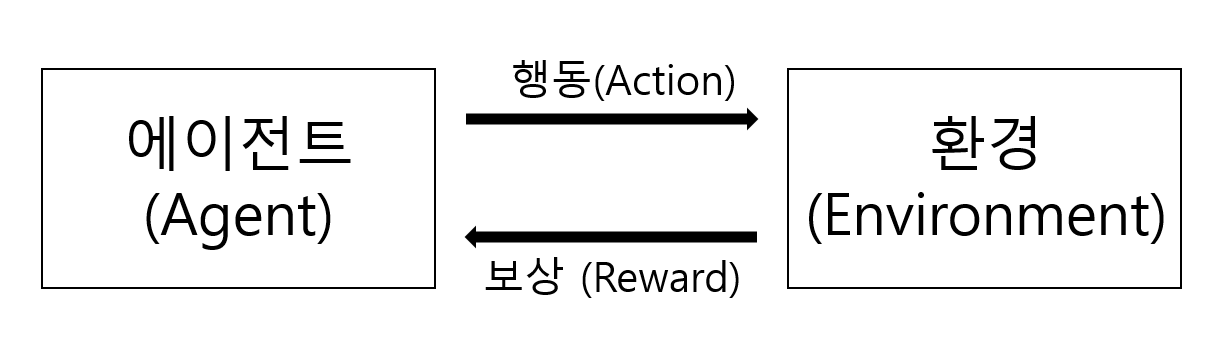

In [2]:
import gymnasium as gym 

import numpy as np  
import tensorflow as tf  
from tensorflow import keras  
from tensorflow.keras import layers  
import random  
import matplotlib.pyplot as plt  
import time

KeyboardInterrupt: 

### 예시 환경들:

- 환경 이름	설명:
  - CartPole-v1	막대기를 수직으로 세우기
  - MountainCar-v0	언덕 넘기
  - Acrobot-v1	로봇 팔 회전시키기
  - LunarLander-v2	달 착륙선 제어하기
  - Atari 게임들	Breakout, Pong 같은 고전 게임

In [ ]:
# gymnasium 예시

env = gym.make('CartPole-v1', render_mode='human')  # 환경 생성
obs, _ = env.reset()

for _ in range(1000):
    env.render()
    action = env.action_space.sample()
    obs, reward, terminated, turncated, info = env.step(action)

    if terminated or turncated:
        obs, _ = env.reset()

env.close()

In [ ]:
# from IPython.display import display, clear_output
# from PIL import Image

# env = gym.make('CartPole-v1', render_mode='rgb_array')  # 환경 생성
# obs, _ = env.reset()

# for _ in range(1000):
#     action = env.action_space.sample()
#     obs, reward, terminated, turncated, info = env.step(action)

#     frame = env.render()

#     clear_output(wait)=True
#     display(Image.fromarray(frame))
#     time.sleep(0.02)

#     if terminated or turncated:
#         obs, _ = env.reset()

# env.close()

## Keras와 Tensorflow로 DQN 구현

1. OpenAI Gym 라이브러리를 사용하여 강화학습 실험에 자주 쓰이는 "CartPole-v1" 환경을 생성하세요. CartPole 환경은 막대기(폴)와 카트(카트)를 사용하여 균형 잡기 문제를 다루는 전형적인 강화학습 예제입니다. 환경을 생성할 때, 환경의 상태가 시각적으로 렌더링되도록 설정하세요.

In [3]:
env = gym.make('CartPole-v1', render_mode='human')  # 환경 생성
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

print(state_size)
print(action_size)

4
2


2. Keras를 활용하여 강화학습 (특히 DQN)에서 사용할 신경망 모델을 구축하세요. 모델의 입력 크기와 에이전트가 취할 수 있는 행동의 개수를 파라미터로 입력 받을 수 있게 작성하세요.  


In [ ]:
def build_model(state_size, action_size):
    model = keras.Sequential([
        layers.Dense(24, activation='relu', input_shape=(state_size,)),
        layers.Dense(24, activation='relu'), 
        layers.Dense(action_size, activation='linear')
    ])
    model.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=0.001))
    return model

model = build_model(state_size, action_size)
model.summary()

c:\Users\ps200\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 24)             │           120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 24)             │           600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │            50 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 770 (3.01 KB)

 Trainable params: 770 (3.01 KB)

 Non-trainable params: 0 (0.00 B)

3. 강화학습에서 경험 재사용(Experience Replay)을 구현하기 위한 버퍼(메모리) 클래스를 정의하겠습니다.  
ReplayBuffer 클래스를 정의하고 ```max_size=2000```를 매개변수로 설정, ```buffer=[]```, ```max_size=max_size```를 초기화 메서드에 추가하세요.

In [ ]:
class ReplayBuffer:
    def __init__(self, max_size=2000):
        self.buffer = []
        self.max_size=max_size

    # 경험 추가 메서드
    def add(self, experience):
        self.buffer.append(experience) # (state, action, reward, next_state, done)
        if len(self.buffer) > self.max_size:
            self.buffer.pop(0)

    # 경험 샘플링 메서드
    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)
    
memory = ReplayBuffer(max_size=2000)

4. 강화학습 에이전트가 행동을 선택할 때 사용하는 ε-탐욕(epsilon-greedy) 전략을 구현하겠습니다.

In [ ]:
# 탐색 매커니즘: 무작위 행동(확률적 ε) 1-ε
# 적용 알고리즘: 값 기반(DQN, ...)
# 행동 공간: 이산 전용

def select_action(state, epsilon):
    if np.random.rand() < epsilon:
        return np.random.choice(action_size)
    else:
        q_values = model.predict(state[np.newaxis, :])
        return np.argmax(q_values[0])


5. DQN(Deep Q-Network) 알고리즘에서 신경망 모델을 학습시키기 위한 한 번의 훈련 단계를 구현하겠습니다. 경험 재사용(Experience Replay) 버퍼에 저장된 샘플들을 이용해 모델의 예측값(Q-값)을 업데이트합니다.

In [ ]:
def train_model(model, target_model, memory, batch_size, gamma=0.95):
    if len(memory.buffer) < batch_size:
        return 
    
    batch = memory.sample(batch_size)
    states, actions, rewards, next_states, dones = zip(*batch)

    states = np.array(states)
    next_states = np.array(next_states)

    q_values = model.predict(states)
    next_q_values = target_model.predict(next_states)

    for i in range(batch_size):
        target = rewards[i]
        if not dones[i]:
            target += gamma * np.max(next_q_values[i])

        q_values[i][actions[i]] = target
    
    model.fit(states, q_values, epochs=1, verbose=0)

6. DQN(Deep Q-Network)을 활용하여 에이전트를 CartPole 환경에서 학습시키는 전체적인 학습 루프를 구성 및 실행하는 코드를 작성해주세요.

In [ ]:

num_episodes = 500  
batch_size = 32  
gamma = 0.95  
epsilon = 1.0 
epsilon_decay = 0.995 
epsilon_min = 0.01 
target_update_freq = 10

target_model = build_model(state_size, action_size) 
target_model.set_weights(model.get_weights()) 

for episode in range(num_episodes):
    state = env.reset()[0] 
    total_reward = 0

    for t in range(200):  
        action = select_action(state, epsilon) 
        next_state, reward, done, _, _ = env.step(action)
        
        memory.add((state, action, reward, next_state, done))
        state = next_state
        total_reward += reward

        if done:
            break

    train_model(model, target_model, memory, batch_size, gamma)

    if episode % target_update_freq == 0:  
        target_model.set_weights(model.get_weights())  

    epsilon = max(epsilon_min, epsilon * epsilon_decay) 

    print(f"Episode {episode+1}/{num_episodes}, Total Reward: {total_reward}, Epsilon: {epsilon:.3f}")

env.close

Episode 1/500, Total Reward: 23.0, Epsilon: 0.995
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Episode 2/500, Total Reward: 32.0, Epsilon: 0.990
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Episode 3/500, Total Reward: 21.0, Epsilon: 0.985
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Episode 4/500, Total Reward: 21.0, Epsilon: 0.980
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Episode 5/500, Total Reward: 26.0, Epsilon: 0.975
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Episode 6/500, Total Reward: 25.0, Epsilon: 0.970
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Episode 7/500, Total Reward: 14.0, Epsilon: 0.966
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Episode 8/500, Total Reward: 18.0, Epsilon: 0.961
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3

: 

## 결과 정리

1. 에이전트가 환경에서 수행한 각 에피소드의 누적 보상을 기록한 후, 이를 시각화하여 DQN 학습 진행 상황을 모니터링하는 코드를 작성해주세요.

In [ ]:
rewards = []

for episode in range(num_episodes):
    state = env.reset()[0]
    total_reward = 0

    for t in range(200):
        action = select_action(state, epsilon)
        next_state, reward, done, _, _ = env.step(action)

        memory.add((state, action, reward, next_state, done))
        state = next_state
        total_reward += reward

        if done:
            break

    rewards.append(total_reward)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━

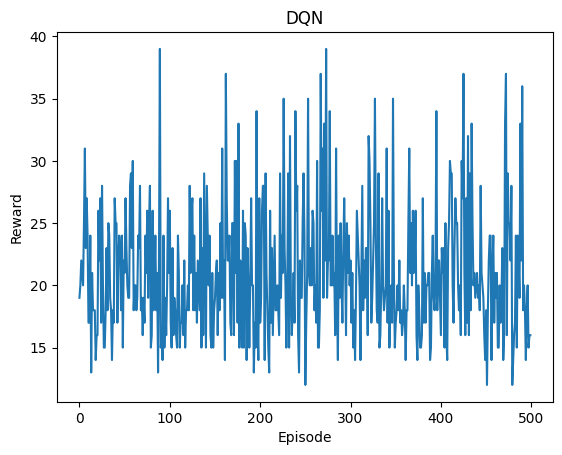

In [ ]:
plt.plot(rewards)
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("DQN")
plt.show()

2. 학습한 DQN을 실제 환경에서 테스트

In [ ]:
state = env.reset()[0]

for _ in range(200):
    action =  np.argmax(model.predict(state[np.newaxis, :]))
    state, _, done, _, _ = env.step(action)
    env.render()

    if done:
        break

env.close

NameError: name 'env' is not defined